In [1]:
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import glob as glob
import scipy.misc


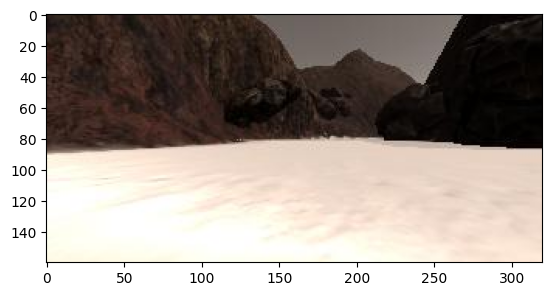

In [8]:
#1)Exploring Data
path = "../test_dataset/IMG/*"
img_list = glob.glob(path)
#glob returns a list of files in this directory (images)
idx = np.random.randint(0,len(img_list)-1) # return a random integer
img = mpimg.imread(img_list[idx]) #read an image 
#mpimg is matplotlib, reads rgb directly
plt.imshow(img)

In [ ]:
#2)Data Calibration
#Read and view Images of the grid and the rock
example_grid = "../calibration_images/example_grid1.jpg"
example_rock = "../calibration_images/example_rock1.jpg"

grid_img = mpimg.imread(example_grid)
rock_img = mpimg.imread(example_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(grid_img)
plt.subplot(122)
plt.imshow(rock_img)

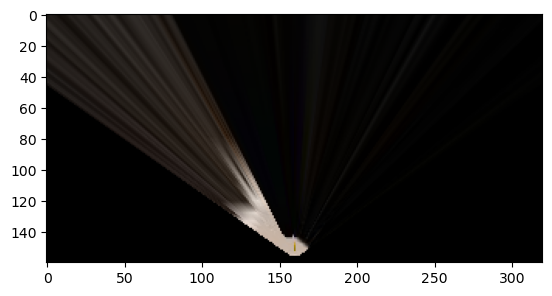

In [4]:
def perspect_transform(img,src,dst):
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img,M,(img.shape[1], img.shape[0]))
    return warped

dst_size = 3
bottom_offset = 5
source = np.float32([[20,137],
                     [300,137],
                     [200,95],
                     [120,95]])

destination = np.float32([[grid_img.shape[1]/2 - dst_size, grid_img.shape[0] - bottom_offset],
                     [grid_img.shape[1]/2 + dst_size,grid_img.shape[0] - bottom_offset],
                     [grid_img.shape[1]/2 + dst_size,grid_img.shape[0] -2*dst_size- bottom_offset],
                     [grid_img.shape[1]/2 - dst_size,grid_img.shape[0] -2*dst_size- bottom_offset]])

warped = perspect_transform(rock_img,source,destination)     
plt.imshow(warped)                
    

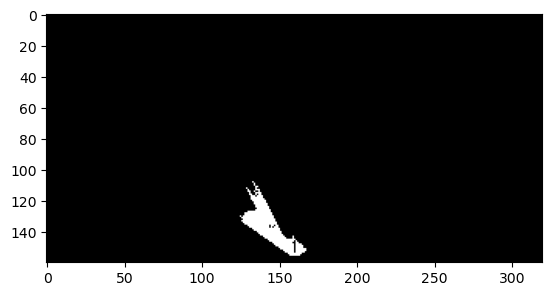

In [5]:
def color_thresh(img, rgb_thresh=(160, 160, 160)):
    # Create an array of zeros same xy size as img, but single channel
    color_select = np.zeros_like(img[:,:,0])
    # Require that each pixel be above all three threshold values in RGB
    # above_thresh will now contain a boolean array with "True"
    # where threshold was met
    above_thresh = (img[:,:,0] > rgb_thresh[0]) \
                & (img[:,:,1] > rgb_thresh[1]) \
                & (img[:,:,2] > rgb_thresh[2])
    # Index the array of zeros with the boolean array and set to 1
    color_select[above_thresh] = 1
    # Return the binary image
    return color_select

threshold = color_thresh(warped)
plt.imshow(threshold,cmap="gray")


[  0   0   0 ... 154 155 155]
[  0   1   2 ... 157 157 158]
[160. 160. 160. ...   6.   5.   5.]


/tmp/ipykernel_32414/3109558195.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
/tmp/ipykernel_32414/3109558195.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)


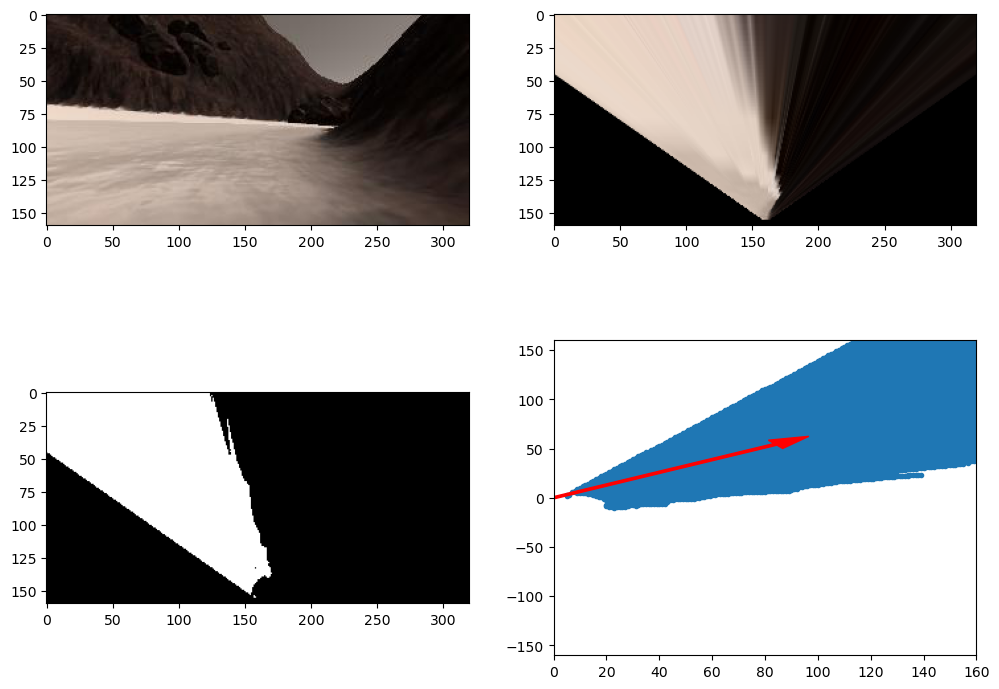

In [11]:
# Define a function to convert from image coords to rover coords
def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    print(ypos)
    print (xpos)
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


# Define a function to convert to radial coords in rover space
def to_polar_coords(x_pixel, y_pixel):
    # Convert (x_pixel, y_pixel) to (distance, angle) 
    # in polar coordinates in rover space
    # Calculate distance to each pixel
    dist = np.sqrt(x_pixel**2 + y_pixel**2)
    # Calculate angle away from vertical for each pixel
    angles = np.arctan2(y_pixel, x_pixel)
    return dist, angles

# Define a function to map rover space pixels to world space
def rotate_pix(xpix, ypix, yaw):
    # Convert yaw to radians
    yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
                            
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    # Return the result  
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    # Return the result  
    return xpix_translated, ypix_translated


# Define a function to apply rotation and translation (and clipping)
# Once you define the two functions above this function should work
def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Perform rotation, translation and clipping all at once
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    # Return the result
    return x_pix_world, y_pix_world



#grab another random image
index = np.random.randint(0,len(img_list)-1)
image = mpimg.imread(img_list[index])
warped = perspect_transform(image,source,destination)
threshold = color_thresh(warped)

#calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix,ypix = rover_coords(threshold)
dist,angles = to_polar_coords(xpix,ypix)
mean_dir = np.mean(angles)

#do some plotting
fig = plt.figure(figsize=(12,9))
plt.subplot(221)
plt.imshow(image)
plt.subplot(222)
plt.imshow(warped)
plt.subplot(223)
plt.imshow(threshold,cmap="gray")
plt.subplot(224)
plt.plot(xpix,ypix,'.')
plt.ylim(-160,160)
plt.xlim(0,160)
arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)
plt.arrow(0,0,x_arrow,y_arrow,color='red',zorder=2,head_width=10,width=2)

